In [139]:
%%capture

###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['raw_adata', 'full_adata',
             'recluster_0','recluster_1','DE_df',
             'diff_2step_df', 'fet_v_adt_df', 'acr_v_cut_df', 'adt_v_fet_DE','target_v_fol_df',
             'ensembl2symbol_dict'
            ]:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
usable_cores = multiprocessing.cpu_count()-1

# update subtypes
full_adata.obs['subtypes'] = ['follicular' if x in ['light_foll_mel', 'dark_foll_mel', 'cyc_foll_mel'] \
                         else y \
                         for x,y in zip(full_adata.obs.class_1, full_adata.obs.subtypes)]

# label order
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['cutaneous','acral','foreskin','follicular']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
follicular_subtype_order = ['follicular','not_follicular']
dev_subtype_order = ['fet_acral','fet_cutaneous','fet_follicular','neo_foreskin','adt_acral','adt_cutaneous']

# create class_2 for site granularity
full_adata.obs['class_2'] = [x if x not in ['mel'] \
                             else f'{y}_mel'
                             for x,y in zip(full_adata.obs['class_1'], full_adata.obs['subtypes'])]

# create class_3 for site+dev_stage granularity
full_adata.obs['class_3'] = [x if not x.endswith('_mel') or x.startswith('cyc_') \
                             else f'{y}_{x}'
                             for x,y in zip(full_adata.obs['class_2'], full_adata.obs['dev_stage'])]

# update class_1 to pool by cell type
full_adata.obs['class_1'] = [x if not x.endswith('_mel') \
                             else 'mel' if not x.startswith('cyc_') \
                             else 'cyc_mel' \
                             for x in full_adata.obs['class_1']]
type_order_1 = ['mel',
                'cyc_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]
    
DE_df['class_1'] = (DE_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order_1, ordered=True))
                     )
DE_df = DE_df.dropna()

type_order_2 = ['cutaneous_mel',
                'acral_mel',
                'foreskin_mel',
                'dark_foll_mel',
                'light_foll_mel',
                'cyc_mel',
                'cyc_foll_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]

type_order_3 = ['adt_cutaneous_mel',
                'adt_acral_mel',
                'neo_foreskin_mel',
                'fet_cutaneous_mel',
                'fet_acral_mel',
                'fet_dark_foll_mel',
                'fet_light_foll_mel',
                'cyc_mel',
                'cyc_foll_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]


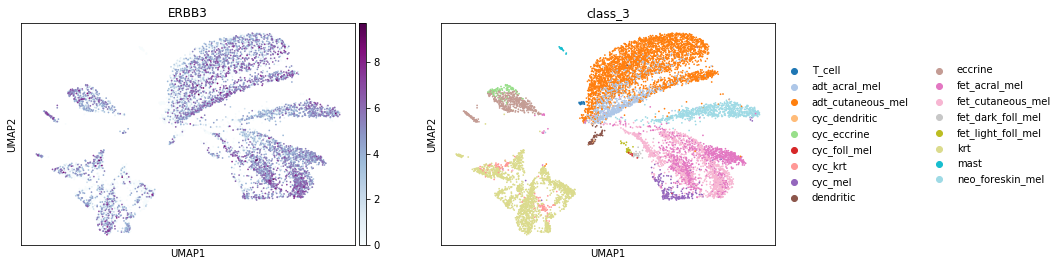

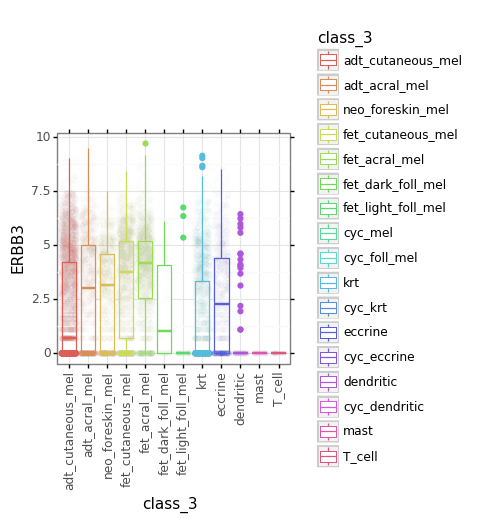

<ggplot: (8762737123420)>
querying 1-1...done.
Finished.
0:  ERBB3 
 This gene encodes a member of the epidermal growth factor receptor (EGFR) family of receptor tyrosine kinases. This membrane-bound protein has a neuregulin binding domain but not an active kinase domain. It therefore can bind this ligand but not convey the signal into the cell through protein phosphorylation. However, it does form heterodimers with other EGF receptor family members which do have kinase activity. Heterodimerization leads to the activation of pathways which lead to cell proliferation or differentiation. Amplification of this gene and/or overexpression of its protein have been reported in numerous cancers, including prostate, bladder, and breast tumors. Alternate transcriptional splice variants encoding different isoforms have been characterized. One isoform lacks the intermembrane region and is secreted outside the cell. This form acts to modulate the activity of the membrane-bound form. Additional spli

In [148]:
# look up gene
gene = 'ERBB3'
groupby = 'class_3'
input_adata = full_adata

sc.pl.umap(input_adata, color = [gene,groupby], cmap='BuPu', palette = 'tab20')

cat, plot_df = prepare_dataframe(input_adata[[not x.startswith('cyc') \
                                              for x in input_adata.obs[groupby]]],
                            gene,
                            groupby
                           )

plot_df = plot_df.reset_index()
plot_df[groupby] = (plot_df[groupby]
                   .astype(str)
                    .astype(CategoricalDtype(type_order_3,ordered=True))
                   )
plot_df = plot_df.dropna()

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes(groupby, gene, color = groupby))
      + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]
